In [1]:
%load_ext autoreload
%autoreload 1

import glob
import numpy as np
import pandas as pd
import scipy
from collections import OrderedDict

import matplotlib.pyplot as plt
%matplotlib widget

import pickle
import os

In [2]:
# Folders to save figures. set values none to prevent saving figures

save_folders = {
    "response_rate_by_block": "./data/figures/response_rates",
    "summary": "./data/figures/summary",
    "correlation": "./data/figures/correlation",
    "callback_rasters_by_block": "./data/figures/callback_rasters_by_block",
    "callback_rasters_multiblock": "./data/figures/callback_rasters_multiblock",
    "violin-n_calls": "./data/figures/violins/n_calls",
    "violin-latency": "./data/figures/violins/latency",
    "histogram-latency": "./data/figures/histograms/latency",
    "histogram-n_calls": "./data/figures/histograms/n_calls",
}

for k, v in save_folders.items():
    if v is not None:
        os.makedirs(v, exist_ok=True)

In [3]:
file = "./data/data.pickle"

with open(file, "rb") as f:
    loaded_data = pickle.load(f)

df = loaded_data["df"]
all_birds = loaded_data["all_birds"]

del loaded_data

df

trial_start_s  trial_end_s  stim_duration_s  \
birdname day block stims_index                                                
gr18bu69 1   0     0                 4.539624     6.674403         0.155215   
                   1                 6.674403     9.191932         0.151767   
                   2                 9.191932    11.604473         0.139421   
                   3                11.604473    14.214170         0.150624   
                   4                14.214170    15.231342         0.135456   
...                                       ...          ...              ...   
pk81rd39 3   9     9                24.033292    27.098310         0.143663   
                   10               27.098310    29.239676         0.147698   
                   11               29.239676    31.098234         0.142542   
                   12               31.098234    32.862232         0.155216   
                   13               32.862232    34.086893         0.151020   

                                          calls_in_range  \
birdname day block stims_index                             
gr18bu69 1   0     0                              [1, 2]   
                   1              [4, 5, 6, 7, 8, 9, 10]   
                   2                [12, 13, 14, 15, 16]   
                   3            [18, 19, 20, 21, 22, 23]   
                   4                    [23, 25, 26, 27]   
...                                                  ...   
pk81rd39 3   9     9                            [27, 28]   
                   10                           [30, 31]   
                   11                           [33, 34]   
                   12                           [36, 37]   
                   13                               [39]   

                                                          call_times_stim_aligned  \
birdname day block stims_index                                                      
gr18bu69 1   0     0            [[0.557610034942627, 0.6310633964061951], [1.2...   
                   1            [[0.193976288810771, 0.31964473800863225], [0....   
                   2            [[0.15544715157167133, 0.3274423145355385], [0...   
                   3            [[0.2118062858275529, 0.3161215140432798], [0....   
                   4            [[-0.16002429700365184, 0.010610820421206313],...   
...                                                                           ...   
pk81rd39 3   9     9            [[0.14057834468293606, 0.19134513474110904], [...   
                   10           [[0.15032897262813094, 0.19537873690261875], [...   
                   11           [[0.14460774976711477, 0.2231829200133184], [1...   
                   12           [[0.19690878295099168, 0.2754839531971953], [1...   
                   13                  [[0.1614188778269252, 0.2483753995660578]]   

                                n_calls  latency_s  \
birdname day block stims_index                       
gr18bu69 1   0     0                  2   0.557610   
                   1                  7   0.193976   
                   2                  5   0.155447   
                   3                  6   0.211806   
                   4                  3   0.265394   
...                                 ...        ...   
pk81rd39 3   9     9                  2   0.140578   
                   10                 2   0.150329   
                   11                 2   0.144608   
                   12                 2   0.196909   
                   13                 1   0.161419   

                                                                     wav_filename  \
birdname day block stims_index                                                      
gr18bu69 1   0     0            /Volumes/AnxietyBU/callbacks/gr18bu69/d1-basel...   
                   1            /Volumes/AnxietyBU/callbacks/gr18bu69/d1-basel...   
                   2            /Volumes/AnxietyBU/callbacks/gr18bu69/d1-b

In [4]:
### Plotting Parameters
day_colors = {1: "#a2cffe", 2: "#840000", 3: "#4e77a3"}
day_labels = {1: "baseline"}  # note: removed D2 label, since not all birds get D2 loom.

stim_kwargs = dict(alpha=0.5)
call_kwargs = dict(color="black", alpha=0.5)

dpi_setting = 600  # None for jupyter output; 600+ for high-quality sharing

### Construct block-by-block response rates

In [5]:
df_block_response_rate = df.groupby(level=["birdname", "day", "block"]).agg(
    pct_trials_responded=("n_calls", lambda x: np.count_nonzero(x) / len(x)),
    n_trials=("n_calls", lambda x: len(x)),
)
df_block_response_rate

pct_trials_responded  n_trials
birdname day block                                
gr18bu69 1   0                       1.0        15
             1                       1.0        13
             2                       1.0        17
             3                       1.0        15
             4                       1.0        16
...                                  ...       ...
pk81rd39 3   5                       1.0        14
             6                       1.0        15
             7                       1.0        14
             8                       1.0        16
             9                       1.0        14

[190 rows x 2 columns]

### Plot response rate by block

In [6]:
%%capture  
# %%capture prevents plot output

save_folder = save_folders['response_rate_by_block']

for birdname in all_birds:
    fig, ax = plt.subplots(dpi=dpi_setting)

    bird_data = df_block_response_rate.loc[birdname]

    days = np.unique(bird_data.index.get_level_values("day"))

    for day in days:
        day_data = bird_data.loc[day]
        dc = day_colors.get(day, f'C{day}')
        dl = day_labels.get(day, f'day{day}')

        ax.plot(
            day_data.index,
            day_data["pct_trials_responded"],
            marker="o",
            color=dc,
            label=dl,
        )

    ax.set(
        xlabel="Block",
        ylabel="Response rate\n(% blocks with ≥ 1 response)",
        title=birdname,
        ylim=[-0.05, 1.05],
    )

    ax.legend()
    
    if save_folder is not None:
        fig.savefig(f'{save_folder}/{birdname}-response_rate.png')

### Plot Response Rates Across Days

In [7]:
# load tempo data

tempo_data = pd.read_csv(
    "/Users/cirorandazzo/code/callback-analysis/data/loom_tempos.csv", index_col="bird"
)

tempo_colors = {"fast": "#EE4E4E", "slow": "#FFC700"}

tempo_data["color"] = tempo_data["family_category"].map(tempo_colors)

# add control birds


control_birds = ["or91rd13", "gr44bu34"]

for bird in control_birds:
    control_bird = pd.DataFrame.from_records(
        [
            dict(
                bird=bird,
                color="#0C1844",
                family_category="no loom",
            )
        ],
        index="bird",
    )

    tempo_data = pd.concat([tempo_data, control_bird])

tempo_data

,family_category,median song tempo,song tempo source,solitary ici,median ici,ici source,color
bird,,,,,,,
gr18bu69,fast,7.487900,eric slack,0.699569,0.807869,tati slack,#EE4E4E
gr3bu36,fast,7.341500,eric slack,NaN,NaN,NEED,#EE4E4E
or12pu24,fast,7.676686,Google sheet; early screening song tempo,NaN,NaN,NaN,#EE4E4E
or13pu25,fast,NaN,NaN,NaN,NaN,NEED,#EE4E4E
or14pu27,fast,7.642357,Google sheet; early screening song tempo,0.719869,0.747452,NaN,#EE4E4E
or54rd45,slow,6.590179,eric slack,0.964156,1.201507,NaN,#FFC700
or60rd49,slow,6.265482,eric slack,NaN,NaN,NEED,#FFC700
pk44rd13,slow,5.184825,Google sheet; early screening song tempo,1.264225,1.389820,NaN,#FFC700
pk63rd15,slow,4.886023,eric slack,NaN,NaN,NEED,#FFC700


In [8]:
df_day = df.groupby(level=["birdname", "day"]).agg(
    mean_n_calls=("n_calls", "mean"),
    mean_n_calls_excl_zero=("n_calls", lambda x: np.sum(x) / np.count_nonzero(x)),
    median_latency_s=("latency_s", lambda x: np.nanmedian(x)),  # median ignoring nans
    pct_trials_responded=("n_calls", lambda x: np.count_nonzero(x) / len(x)),
    n_trials_no_response=("n_calls", lambda x: len(x) - np.count_nonzero(x)),
    n_trials=("n_calls", lambda x: len(x)),
)
df_day

mean_n_calls  mean_n_calls_excl_zero  median_latency_s  \
birdname day                                                           
gr18bu69 1        2.848684                2.848684          0.207456   
         2        0.234483                2.428571          0.241214   
gr3bu36  1        1.802632                2.157480          0.200054   
         2        1.258993                1.822917          0.575540   
gr44bu34 1        1.132450                1.461538          0.291434   
         2        1.408163                1.592308          0.289175   
or14pu27 1        2.864516                2.940397          0.204664   
         2        1.809160                1.991597          0.224201   
or54rd45 1        0.930070                1.705128          0.408918   
         2        1.136691                1.795455          0.599973   
or60rd49 1        1.760684                1.925234          0.201622   
         2        1.790698                1.893443          0.248457   
or91rd13 1        1.596330                1.812500          0.283585   
         2        1.396947                1.678899          0.228917   
pk63rd15 1        2.651316                2.760274          0.252232   
         2        1.920863                2.752577          0.265463   
pk81rd39 1        2.017094                2.070175          0.175674   
         2        2.250000                2.316176          0.273741   
         3        1.845070                1.884892          0.162430   

              pct_trials_responded  n_trials_no_response  n_trials  
birdname day                                                        
gr18bu69 1                1.000000                     0       152  
         2                0.096552                   131       145  
gr3bu36  1                0.835526                    25       152  
         2                0.690647                    43       139  
gr44bu34 1                0.774834                    34       151  
         2                0.884354                    17       147  
or14pu27 1                0.974194                     4       155  
         2                0.908397                    12       131  
or54rd45 1                0.545455                    65       143  
         2                0.633094                    51       139  
or60rd49 1                0.914530                    10       117  
         2                0.945736                     7       129  
or91rd13 1                0.880734                    13       109  
         2                0.832061                    22       131  
pk63rd15 1                0.960526                     6       152  
         2                0.697842                    42       139  
pk81rd39 1                0.974359                     3       117  
         2                0.971429                     4       140  
         3                0.978873                     3       142

### Pre/post summary plots

- n_calls
- latency
- response rate

In [9]:
%%capture

#TODO: add option to specify days (eg, exclude d3)

import matplotlib.patches as mpatches

%aimport utils.plot
from utils.plot import plot_pre_post

save_folder = save_folders['summary']
highlight_bird = None
# highlight_bird = 'pk81rd39'

to_plot_pre_post = {
    "n_calls" : dict(
        fieldname="mean_n_calls",
        ax_kwargs = dict(
            title="Mean Calls/Trial Across Days",
            ylabel="Mean # Calls per Trial",
            ylim=[-0.1,3]
        )
    ),
    
    "n_calls_excl_zero" : dict(
        fieldname="mean_n_calls_excl_zero",
        ax_kwargs = dict(
            title="Mean Calls/Trial Across Days (Excl. 0)",
            ylabel="Mean # Calls per Trial",
            ylim=[0.9,3]
        )
    ),
    
    "latency" : dict(
        fieldname="median_latency_s", 
        ax_kwargs = dict(
            title="Median Latency Across Days",
            ylabel="Median Latency (s)",
        )
    ),
    
    "response_rate" : dict(
        fieldname="pct_trials_responded", 
        ax_kwargs = dict(
            yticks=np.arange(0, 1.2, 0.2),
            title="Response Rate Across Days",
            ylabel="% Trials with ≥1 Response",
        )
    ),
}

# proxy artists for legend
handles = [
    mpatches.Patch(color=color, label=speed)
    for speed, color in tempo_colors.items()
]

for fname, parameters in to_plot_pre_post.items():

    fig, ax = plt.subplots(figsize=[4, 6], dpi=dpi_setting)

    ax_kwargs = parameters.get('ax_kwargs', {})

    ax = plot_pre_post(
        df_day, 
        fieldname=parameters['fieldname'], 
        ax=ax,
        color=tempo_data,
        plot_kwargs={'marker': 'o'},
        add_bird_label=True,  # default: false. adds bird ids on plot
    )

    if highlight_bird is not None:
        fname += f"-{highlight_bird}"

        ax = plot_pre_post(
            df_day.xs(highlight_bird, level="birdname", drop_level=False),
            fieldname=parameters['fieldname'], 
            ax=ax,
            color='green',
            plot_kwargs={'marker': 'o', 'linestyle':'--'}
        )

    ax.set(
        xticks=[1, 2, 3],
        # xlim=[0.75, 2.25],  # if no bird labels
        xlim=[0.75, 3.5],  # if bird labels
        # xticklabels=["baseline", "loom"],
        xlabel='Day',
        # yticks=np.arange(0, 1.2, 0.2),
        **ax_kwargs,
    )

    if save_folder is not None:
        fig.savefig(f"{save_folder}/{fname}.png", bbox_inches="tight")

        # ax.legend(handles=handles)

        # fig.savefig(f"./data/figures/summary/{fname}-legend.png", bbox_inches="tight")

### Deltas & Correlation

In [10]:
# scatter plot kwargs for correlation plot
corr_kwargs = dict(
    marker="o",
    color="k",
)

# regression line kwargs for correlation plot
corr_reg_kwargs = dict(
    color="k",
    linestyle="--",
)

In [11]:
df_day

mean_n_calls  mean_n_calls_excl_zero  median_latency_s  \
birdname day                                                           
gr18bu69 1        2.848684                2.848684          0.207456   
         2        0.234483                2.428571          0.241214   
gr3bu36  1        1.802632                2.157480          0.200054   
         2        1.258993                1.822917          0.575540   
gr44bu34 1        1.132450                1.461538          0.291434   
         2        1.408163                1.592308          0.289175   
or14pu27 1        2.864516                2.940397          0.204664   
         2        1.809160                1.991597          0.224201   
or54rd45 1        0.930070                1.705128          0.408918   
         2        1.136691                1.795455          0.599973   
or60rd49 1        1.760684                1.925234          0.201622   
         2        1.790698                1.893443          0.248457   
or91rd13 1        1.596330                1.812500          0.283585   
         2        1.396947                1.678899          0.228917   
pk63rd15 1        2.651316                2.760274          0.252232   
         2        1.920863                2.752577          0.265463   
pk81rd39 1        2.017094                2.070175          0.175674   
         2        2.250000                2.316176          0.273741   
         3        1.845070                1.884892          0.162430   

              pct_trials_responded  n_trials_no_response  n_trials  
birdname day                                                        
gr18bu69 1                1.000000                     0       152  
         2                0.096552                   131       145  
gr3bu36  1                0.835526                    25       152  
         2                0.690647                    43       139  
gr44bu34 1                0.774834                    34       151  
         2                0.884354                    17       147  
or14pu27 1                0.974194                     4       155  
         2                0.908397                    12       131  
or54rd45 1                0.545455                    65       143  
         2                0.633094                    51       139  
or60rd49 1                0.914530                    10       117  
         2                0.945736                     7       129  
or91rd13 1                0.880734                    13       109  
         2                0.832061                    22       131  
pk63rd15 1                0.960526                     6       152  
         2                0.697842                    42       139  
pk81rd39 1                0.974359                     3       117  
         2                0.971429                     4       140  
         3                0.978873                     3       142

In [12]:
# takes d2 - d1
d2minusD1 = lambda x: x.loc[:, 2] - x.loc[:, 1]

delta_df = df_day.groupby("birdname").agg(
    d_pct_trials_responded=("pct_trials_responded", d2minusD1),
    d_mean_n_calls=("mean_n_calls", d2minusD1),
    d_median_latency_s=("median_latency_s", d2minusD1),
)

# get song tempo & callback latency
delta_df["song_tempo"] = delta_df.index.map(tempo_data["median song tempo"])
# delta_df["callback_latency"] = delta_df.index.map(tempo_data["callback latency"])

delta_df

,d_pct_trials_responded,d_mean_n_calls,d_median_latency_s,song_tempo
birdname,,,,
gr18bu69,-0.903448,-2.614201,0.033758,7.487900
gr3bu36,-0.144879,-0.543639,0.375486,7.341500
gr44bu34,0.109519,0.275713,-0.002259,NaN
or14pu27,-0.065797,-1.055356,0.019537,7.642357
or54rd45,0.087639,0.206621,0.191055,6.590179
or60rd49,0.031207,0.030014,0.046835,6.265482
or91rd13,-0.048673,-0.199384,-0.054667,NaN
pk63rd15,-0.262685,-0.730452,0.013231,4.886023
pk81rd39,-0.002930,0.232906,0.098067,6.261500


In [13]:
axis_labels_by_field = {
    "song_tempo": "Median song tempo\n(syl/s)",
    "d_pct_trials_responded": "$\Delta$ % trials with ≥1 response",
    "d_mean_n_calls": "$\Delta$ mean call count/trial",
    "d_median_latency_s": "$\Delta$ median latency (s)",
}


correlations_to_plot = {
    "C--song_tempo-response_rate": dict(
        x_field="song_tempo",
        y_field="d_pct_trials_responded",
        ax_kwargs=dict(
            title="$\Delta$ response rate vs. song tempo",
        ),
    ),
    "C--song_tempo-n_calls": dict(
        x_field="song_tempo",
        y_field="d_mean_n_calls",
        ax_kwargs=dict(
            title="$\Delta$ mean calls/trial vs. Song tempo",
        ),
    ),
    "C--song_tempo-latency": dict(
        x_field="song_tempo",
        y_field="d_median_latency_s",
        ax_kwargs=dict(
            title="$\Delta$ median latency vs. Song tempo",
        ),
    ),
}

In [14]:
%%capture

save_folder = save_folders['correlation']

for fname, parameters in correlations_to_plot.items():
    x_field = parameters["x_field"]
    y_field = parameters["y_field"]
    x = delta_df[x_field]
    y = delta_df[y_field]

    ii = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[ii], y[ii]
    

    fig, ax = plt.subplots(dpi=dpi_setting)
    ax.scatter(x, y, **corr_kwargs, label=None)

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=x, y=y)
    p = lambda x: slope*x + intercept
    eq_string = "$%.3ex + %.6f$\n$r=%.3f$"%(slope, intercept, r_value)

    ends = np.array([np.min(x), np.max(x)])

    ax.plot(ends, p(ends), label=eq_string, **corr_reg_kwargs)

    ax.set(
        xlabel=axis_labels_by_field[x_field],
        ylabel=axis_labels_by_field[y_field],
        **parameters["ax_kwargs"],
    )

    ax.legend(loc='best')

    if save_folder is not None:
        fig.savefig(f"{save_folder}/{fname}.png", bbox_inches="tight")

In [15]:
# savefig = False

# fig, ax = plt.subplots(dpi=dpi_setting)

# ax.scatter(delta_df["song_tempo"], delta_df[""], **corr_kwargs)

# ax.set(
#     # xlim=[4.5, 8],
# )

# if savefig:
#     fig.savefig(f"./data/figures/correlation/{fname}.png", bbox_inches="tight")

In [16]:
plt.close("all")

## Plot Rasters

### Raster by block

In [17]:
%%capture  
# %%capture prevents plot output

%aimport utils.plot
from utils.plot import plot_callback_raster

save_folder = save_folders['callback_rasters_by_block']

# every bird/day/block
unique_conditions = list(set([a[0:3] for a in df.index]))

## or select a subset
# unique_conditions = [
#     ('or14pu27', 1, 1),
#     ('or14pu27', 2, 1),
#     ('or54rd45', 1, 1),
#     ('or54rd45', 2, 1),
# ]

# figs = {}

for bird, day, block in unique_conditions:

    fig = plt.figure()
    ax = fig.subplots()

    data = df.loc[(bird, day, block)]
    
    title_str = f'{bird}-d{day}-b{block}'

    stim_kwargs['color'] = day_colors[day]

    plot_callback_raster(
        data,
        ax=ax,
        title = title_str,
        plot_stim_blocks = False,
        show_legend = True,
        call_kwargs = call_kwargs,
        stim_kwargs = stim_kwargs,
    )

    ax.set_xlim([-0.1, 3])

    # figs[title_str] = fig

    if save_folder is not None:
        fig.savefig(f'{save_folder}/{title_str}.png')

### Raster by day

In [18]:
%%capture  
# %%capture prevents plot output

%aimport utils.plot
from utils.plot import plot_callback_raster_multiblock

save_folder = save_folders['callback_rasters_multiblock']

# every bird/day
unique_conditions = list(set([a[0:2] for a in df.index]))

for bird, day in unique_conditions:
    data = df.loc[(bird, day)]

    title_str = f"{bird}-d{day}"

    stim_kwargs = dict(color=day_colors[day], alpha=0.5, edgecolor=None)
    call_kwargs = dict(color="black", alpha=0.5, edgecolor=None)

    fig = plt.figure()
    ax = fig.subplots()

    plot_callback_raster_multiblock(
        data,
        ax=ax,
        plot_hlines=True,
        show_block_axis=True,
        show_legend=False,
        xlim=[-0.1, 3],
        stim_kwargs = stim_kwargs,
        call_kwargs = call_kwargs,
        title = title_str,
    )

    if save_folder is not None:
        fig.savefig(f'{save_folder}/{title_str}.png')

## Violin plots

In [19]:
# NOTE: violin plot only works for days = [1,2] right now

days = [1, 2]

width = 0.75

In [20]:
%%capture  
# %%capture prevents plot output

%aimport utils.plot
from utils.plot import plot_violins_by_block

save_folder =  save_folders['violin-n_calls']

for bird in all_birds:
    fig, ax = plt.subplots(dpi=dpi_setting)
    title_str = bird

    ax = plot_violins_by_block(
            df.loc[bird],
            field="n_calls",
            ax=ax,
            days=days,
            day_colors=day_colors,
            width=width,
            dropna=False,
    )

    ax.set(
        xlim=[-0.5,9.5],
        xticks= np.arange(0,10),
        # ylim=[-.5, 8],
        xlabel='Block',
        ylabel='Calls per stimulus',
        title=title_str,
    )
    
    if save_folder is not None:
        fig.savefig(f'{save_folder}/{title_str}.png')

In [21]:
%%capture  
# %%capture prevents plot output

%aimport utils.plot
from utils.plot import plot_violins_by_block

save_folder =  save_folders['violin-latency']

for bird in all_birds:
    fig, ax = plt.subplots(dpi=dpi_setting)
    title_str = bird

    ax = plot_violins_by_block(
            df.loc[bird],
            field="latency_s",
            ax=ax,
            days=days,
            day_colors=day_colors,
            width=width,
            dropna=True,
    )

    ax.set(
        xlim=[-0.5,9.5],
        xticks= np.arange(0,10),
        # ylim=[0, 2.5],
        xlabel='Block',
        ylabel='Latency to first call (s)',
        title=title_str,
    )
    
    if save_folder is not None:
        fig.savefig(f'{save_folder}/{title_str}.png')

## Histograms

All blocks merged

### Latency

In [22]:
%%capture

# index levels: 'birdname', 'day', 'block', 'stims_index'
# idx = pd.IndexSlice
# this_bird = df.loc[idx[birdname, :, :, :]]

save_folder = save_folder['histogram-latency']

%aimport utils.plot
from utils.plot import plot_group_hist

for bird in all_birds:

    fig, ax = plt.subplots(dpi=dpi_setting)

    plot_group_hist(
        df.loc[bird],
        field="latency_s",
        grouping_level="day",
        group_colors=day_colors,
        alt_labels=day_labels,
        ax=ax,
        density=True,
        ignore_nan=True,
        histogram_kwargs={
            "range": (0, 1.5),
            "bins": 40,
        },
        stair_kwargs={
            1: {"hatch": "/"},
            2: {"hatch": "\\"},
        },
    )

    ax.set(
        title=f"{bird}: latency to first call",
        xlabel="Latency (s)",
    )

    if save_folder is not None:
        fig.savefig(f'{save_folder}/{bird}-latency.png')

TypeError: string indices must be integers, not 'str'

In [23]:
%%capture

save_folder = save_folders['histogram-n_calls']

%aimport utils.plot
from utils.plot import plot_group_hist

for bird in all_birds:

    fig, ax = plt.subplots(dpi=dpi_setting)

    plot_group_hist(
        df.loc[bird],
        field="n_calls",
        grouping_level="day",
        group_colors=day_colors,
        alt_labels=day_labels,
        ax=ax,
        density=True,
        ignore_nan=False,
        histogram_kwargs={
            "range": (-0.5, 9.5),
            "bins": 10,
        },
        stair_kwargs={
            1: {"hatch": "/"},
            2: {"hatch": "\\"},
        },
    )

    ax.set(
        title=f"{bird}: number of calls per trial",
        xlabel="# of calls",
        xticks=list(range(0, 10)),
    )

    if save_folder is not None:
        fig.savefig(f"{save_folder}/{bird}-ncalls.png")

KeyError: 2

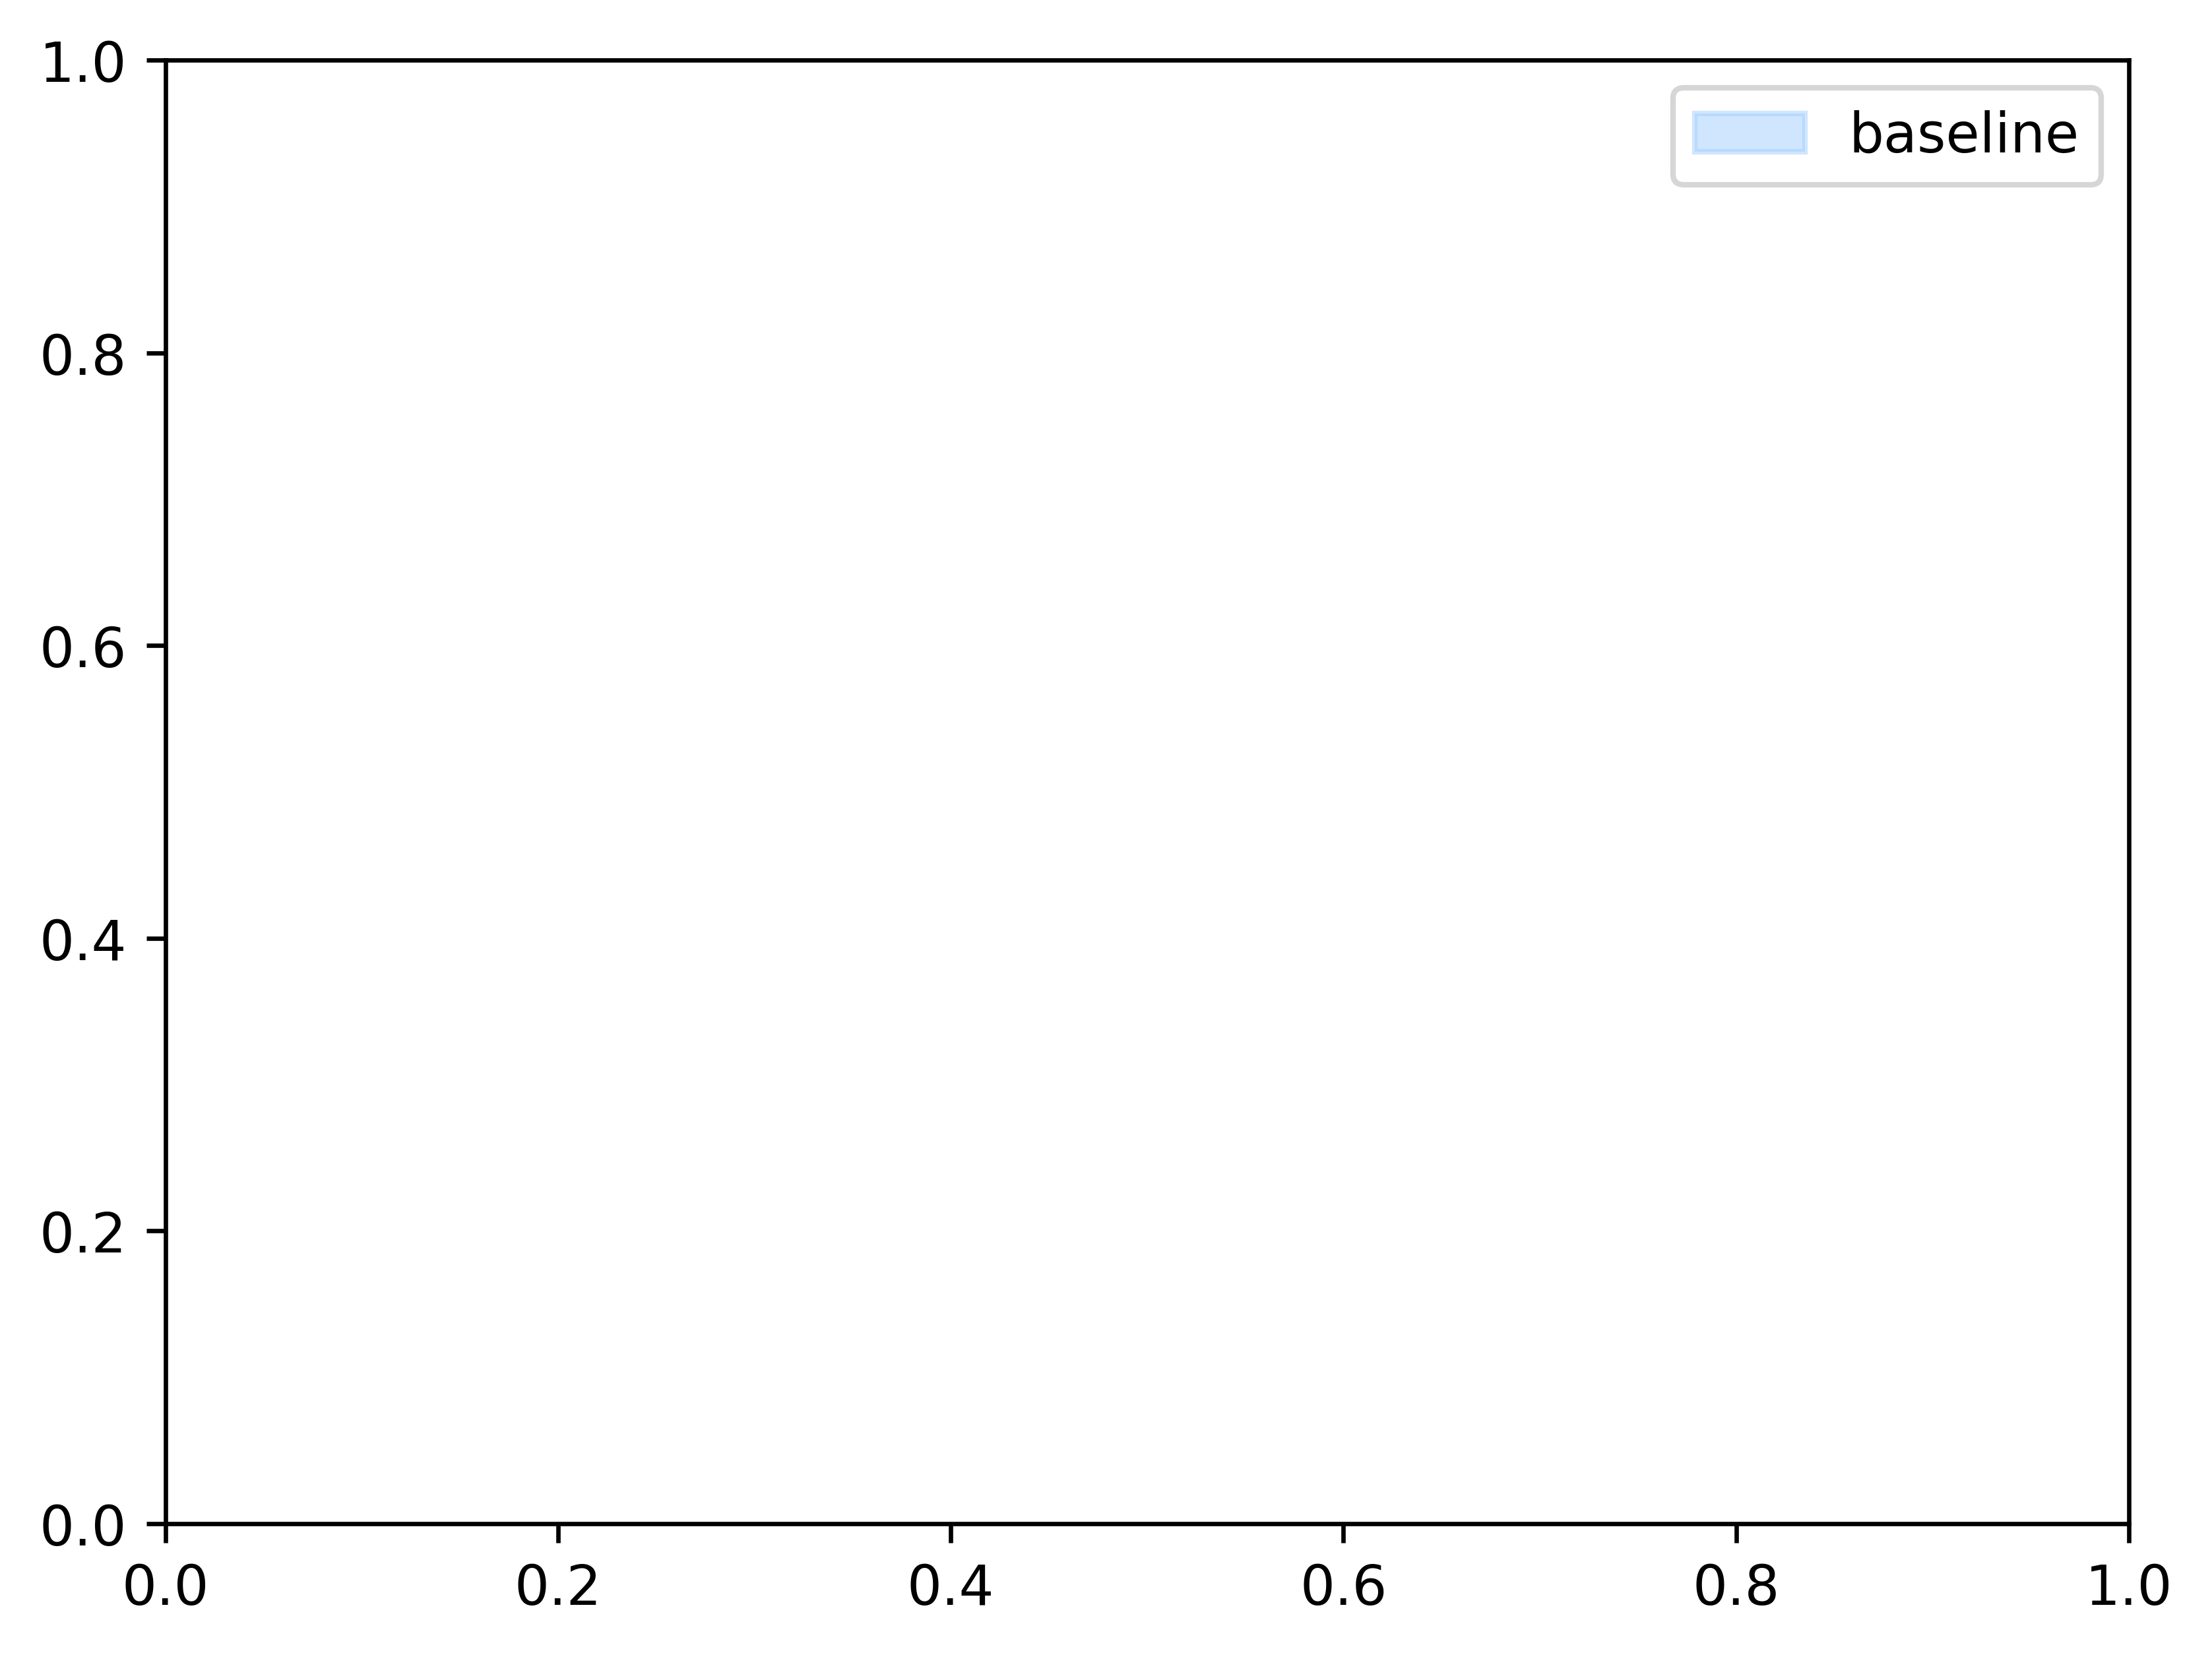

In [24]:
# to generate legend

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

alpha = 0.5

fig, ax = plt.subplots(dpi=dpi_setting)

handles = []
for k, v in day_labels.items():
    handles.append(
        Rectangle([0, 0], 0, 0, color=day_colors[k], alpha=alpha, label=day_labels[k])
    )

ax.legend(handles=handles)

plt.show()

TODO

In [25]:
# TODO: maybe replace some hacky indexing stuff with `groupby`. eg:
df["n_calls"].groupby(level=["birdname", "day"]).mean()

birdname  day
gr18bu69  1      2.848684
          2      0.234483
gr3bu36   1      1.802632
          2      1.258993
gr44bu34  1      1.132450
          2      1.408163
or14pu27  1      2.864516
          2      1.809160
or54rd45  1      0.930070
          2      1.136691
or60rd49  1      1.760684
          2      1.790698
or91rd13  1      1.596330
          2      1.396947
pk63rd15  1      2.651316
          2      1.920863
pk81rd39  1      2.017094
          2      2.250000
          3      1.845070
Name: n_calls, dtype: float64